# VarAnneal Tutorial

## Introduction
VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.  VarAnneal is hosted on GitHub at [github.com/paulrozdeba/varanneal](http://github.com/paulrozdeba/varanneal).

In variational data assimilation, statistical path estimates conditioned on observational data are calculated using high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  These integrals may be approximated using Laplace's method around the dominant peaks of $P(X\lvert Y)$.  VA uses an annealing-like, numerical continuation method for finding these peaks using numerical optimization.  This optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed with automatic differentiation (AD) using the PYADOLC wrapper around ADOL-C.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

## Neural Network Example 1: All-to-All Feed-Forward Network for MNIST Image Recognition

In [2]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [3]:
from varanneal import va_nnet

#### Data
$M$ pairs of data, each consisting of a handwritten image (the input) and a label for the image, which is which digit a human decides the image is of (the output), forming the data $Y$.

#### Model
Here we use an all-to-all feed-forward neural network with 3 layers: one input, one output, and one hidden layer.  The input and output layer sizes are fixed by the number of pixels in each image and the number of possible labels, respectively.

The state of the network, $X$, is a collection of neuron activations in each layer:
$$
X = \left\{ \mathbf{x}^{l_1}, \mathbf{x}^{l_2}, \ldots, \mathbf{x}^{l_F} \right\}
$$

The state of the network in layer $l_n$ is transferred to layer $l_{n+1}$ according to the activation function:
$$
\mathbf{x}^{n+1} = \sigma(\mathbf{x}^{n}, \mathbf{W}^{n+1}) = \frac{1}{1 + \exp \left[-\mathbf{W}^{n+1} \cdot \mathbf{x}^n \right]}
$$
where $\mathbf{W}^n$ is the matrix of "synaptic" weights between layer $n-1$ and $n$.

#### Define the activation function

In [16]:
def sigmoid(x, W, b):
    linpart = np.dot(W, x) + b
    return 1.0 / (1.0 + np.exp(-linpart))

#### Network structure

In [60]:
N = 4  # Total number of layers
D_in = 3  # Number of neurons in the input layer
D_out = 4  # Number of neurons in the output layer
D_hidden = 200  # Number of neurons in the hidden layers

# Network structure is stored in a list, where element i is the number 
# of neurons in layer i.
structure = np.zeros(N, dtype='int')
structure[0] = D_in  # 3 neurons in the input layer
structure[N-1] = D_out  # 2 neurons in the output layer
for i in range(1, N-1):
    structure[i] = D_hidden  # 5 neurons in the hidden layers

Lidx = [np.linspace(0, D_in-1, D_in, dtype='int'), np.linspace(0, D_out-1, D_out, dtype='int')]

#### Action/annealing parameters

In [61]:
# RM, RF0
RM = 1.0
RF0 = 1.0e-8 * RM * float(np.sum(structure) - structure[0]) / float(structure[0] + structure[-1])
g0 = RF0 / RM

# alpha, and beta ladder
alpha = 1.1
beta_array = np.linspace(0, 435, 436)
gammas_all = g0 * alpha**beta_array

#### Load data set (3 in, 4 out)

In [76]:
M = 10  # number of training examples
data = np.load('l96/data/l96_data_N5.npy') # has 5 l96 variables
Didx = 0


T = data.shape[0]

data_in = np.zeros((M, D_in))
data_out = np.zeros((M, D_out))

for i in xrange(M):
    data_in[i] = data[i:i+D_in, Didx]
    data_out[i] = data[i+D_in:i+D_in+D_out, Didx]

#### Initial neuron activation/weight guesses

In [77]:
np.random.seed(27509436)

# Neuron states
Xin = np.random.randn(D_in)
Xin = (Xin - np.average(Xin)) / np.std(Xin)
X0 = np.copy(Xin)

for n in xrange(N-2):
    X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

for m in xrange(M - 1):
    Xin = np.random.randn(D_in)
    Xin = (Xin - np.average(Xin)) / np.std(Xin)
    X0 = np.append(X0, Xin)
    for n in xrange(N-2):
        X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
    X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

X0 = np.array(X0).flatten()

# Parameters
NP = np.sum(structure[1:]*structure[:-1] + structure[1:])
P0 = np.array([], dtype=np.float64)

W_i0 = 0
W_if = structure[0]*structure[1]
b_i0 = W_if
b_if = b_i0 + structure[1]

# Set up Pidx so that only weights, not biases, are estimated
for n in xrange(N - 1):
    if n == 0:
        Pidx = np.arange(W_i0, W_if, 1, dtype='int')
    else:
        Pidx = np.append(Pidx, np.arange(W_i0, W_if, 1, dtype='int'))
    if n == 0:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_in)
    else:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_hidden)
    P0 = np.append(P0, np.zeros(structure[n+1]))

    if n < N - 2:
        W_i0 = b_if
        W_if = W_i0 + structure[n+1]*structure[n+2]
        b_i0 = W_if
        b_if = b_i0 + structure[n+2]

P0 = np.array(P0).flatten()
Pidx = np.array(Pidx).flatten().tolist()

In [78]:
print(P0.shape)

(41804,)


### Use VA to train the network weights

In [79]:
# Initialize Annealer
anneal1 = va_nnet.Annealer()
# Set the network structure
anneal1.set_structure(structure)
# Set the activation function
anneal1.set_activation(sigmoid)
# Set the input and output data
anneal1.set_input_data(data_in)
anneal1.set_output_data(data_out)

#### Run VA using L-BFGS-B

In [80]:
BFGS_options = {'gtol':1.0e-12, 'ftol':1.0e-12, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()
anneal1.anneal(X0, P0, alpha, beta_array, RM, RF0, Pidx, Lidx=Lidx,
               method='L-BFGS-B', opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 436
beta = 0, RF = 5.77142857e-07

Taping action evaluation...
Done!
Time = 2.80454587936 s

Beginning optimization...
Optimization complete!
Time = 2.12592720985 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 10
Obj. function value = [  3.02420518e-07]

------------------------------
Step 2 of 436
beta = 1, RF = 6.34857143e-07

Taping action evaluation...
Done!
Time = 1.76667714119 s

Beginning optimization...
Optimization complete!
Time = 0.390944957733 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.32662326e-07]

------------------------------
Step 3 of 436
beta = 2, RF = 6.98342857e-07

Taping action evaluation...
Done!
Time = 2.45084500313 s

Beginning optimization...
Optimization complete!
Time = 0.512946128845 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = 

Done!
Time = 2.11972498894 s

Beginning optimization...
Optimization complete!
Time = 2.45715689659 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 10
Obj. function value = [  2.80714395e-06]

------------------------------
Step 26 of 436
beta = 25, RF = 6.25317314e-06

Taping action evaluation...
Done!
Time = 2.10830307007 s

Beginning optimization...
Optimization complete!
Time = 0.406128883362 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.08785791e-06]

------------------------------
Step 27 of 436
beta = 26, RF = 6.87849046e-06

Taping action evaluation...
Done!
Time = 2.15844988823 s

Beginning optimization...
Optimization complete!
Time = 0.458895921707 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.39664320e-06]

------------------------------
Step 28 of 436
beta = 27, RF = 7.56633950e-06

Ta

Done!
Time = 2.07132101059 s

Beginning optimization...
Optimization complete!
Time = 10.191024065 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 67
Obj. function value = [  2.71968996e-05]

------------------------------
Step 50 of 436
beta = 49, RF = 6.15920838e-05

Taping action evaluation...
Done!
Time = 2.19247889519 s

Beginning optimization...
Optimization complete!
Time = 0.401385068893 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  2.99165866e-05]

------------------------------
Step 51 of 436
beta = 50, RF = 6.77512922e-05

Taping action evaluation...
Done!
Time = 2.17768096924 s

Beginning optimization...
Optimization complete!
Time = 0.405385017395 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.29082416e-05]

------------------------------
Step 52 of 436
beta = 51, RF = 7.45264215e-05

Tap

Optimization complete!
Time = 1.4084341526 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 0.00026787]

------------------------------
Step 74 of 436
beta = 73, RF = 6.06665561e-04

Taping action evaluation...
Done!
Time = 2.10129308701 s

Beginning optimization...
Optimization complete!
Time = 0.976564884186 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00029466]

------------------------------
Step 75 of 436
beta = 74, RF = 6.67332117e-04

Taping action evaluation...
Done!
Time = 2.15060710907 s

Beginning optimization...
Optimization complete!
Time = 0.956176996231 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00032413]

------------------------------
Step 76 of 436
beta = 75, RF = 7.34065329e-04

Taping action evaluation...
Done!
Time = 2.16194105148 s

Beginning optimiz

Done!
Time = 2.02323698997 s

Beginning optimization...
Optimization complete!
Time = 1.05650997162 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00290206]

------------------------------
Step 99 of 436
beta = 98, RF = 6.57304296e-03

Taping action evaluation...
Done!
Time = 2.08217906952 s

Beginning optimization...
Optimization complete!
Time = 0.923933029175 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00319223]

------------------------------
Step 100 of 436
beta = 99, RF = 7.23034725e-03

Taping action evaluation...
Done!
Time = 2.08548307419 s

Beginning optimization...
Optimization complete!
Time = 0.751461982727 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.00351142]

------------------------------
Step 101 of 436
beta = 100, RF = 7.95338198e-03

Taping action e

Done!
Time = 2.1408560276 s

Beginning optimization...
Optimization complete!
Time = 0.653485774994 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.03141098]

------------------------------
Step 124 of 436
beta = 123, RF = 7.12169876e-02

Taping action evaluation...
Done!
Time = 2.17948794365 s

Beginning optimization...
Optimization complete!
Time = 0.817410945892 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.03454821]

------------------------------
Step 125 of 436
beta = 124, RF = 7.83386864e-02

Taping action evaluation...
Done!
Time = 2.11014199257 s

Beginning optimization...
Optimization complete!
Time = 0.574499130249 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.03799835]

------------------------------
Step 126 of 436
beta = 125, RF = 8.61725550e-02

Taping actio

Done!
Time = 3.53496408463 s

Beginning optimization...
Optimization complete!
Time = 0.708637952805 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.33661916]

------------------------------
Step 149 of 436
beta = 148, RF = 7.71615119e-01

Taping action evaluation...
Done!
Time = 2.59924006462 s

Beginning optimization...
Optimization complete!
Time = 1.00719285011 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.36983696]

------------------------------
Step 150 of 436
beta = 149, RF = 8.48776631e-01

Taping action evaluation...
Done!
Time = 2.67192816734 s

Beginning optimization...
Optimization complete!
Time = 0.811866998672 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.40628464]

------------------------------
Step 151 of 436
beta = 150, RF = 9.33654294e-01

Taping actio

Done!
Time = 2.22914099693 s

Beginning optimization...
Optimization complete!
Time = 0.753775119781 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 3.26194334]

------------------------------
Step 174 of 436
beta = 173, RF = 8.36022291e+00

Taping action evaluation...
Done!
Time = 2.02314591408 s

Beginning optimization...
Optimization complete!
Time = 0.758026838303 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 3.54686521]

------------------------------
Step 175 of 436
beta = 174, RF = 9.19624521e+00

Taping action evaluation...
Done!
Time = 2.12540102005 s

Beginning optimization...
Optimization complete!
Time = 0.78274512291 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 3.85280329]

------------------------------
Step 176 of 436
beta = 175, RF = 1.01158697e+01

Taping actio

Done!
Time = 2.10827708244 s

Beginning optimization...
Optimization complete!
Time = 1.51830887794 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 8
Obj. function value = [ 16.48117551]

------------------------------
Step 199 of 436
beta = 198, RF = 9.05805569e+01

Taping action evaluation...
Done!
Time = 2.00646710396 s

Beginning optimization...
Optimization complete!
Time = 1.35359597206 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 7
Obj. function value = [ 17.12259989]

------------------------------
Step 200 of 436
beta = 199, RF = 9.96386126e+01

Taping action evaluation...
Done!
Time = 2.05157089233 s

Beginning optimization...
Optimization complete!
Time = 1.15130901337 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 17.75062685]

------------------------------
Step 201 of 436
beta = 200, RF = 1.09602474e+02

Taping acti

Done!
Time = 2.08255505562 s

Beginning optimization...
Optimization complete!
Time = 1.29248404503 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 26.32924464]

------------------------------
Step 224 of 436
beta = 223, RF = 9.81413698e+02

Taping action evaluation...
Done!
Time = 2.02209877968 s

Beginning optimization...
Optimization complete!
Time = 1.25501394272 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 26.4754801]

------------------------------
Step 225 of 436
beta = 224, RF = 1.07955507e+03

Taping action evaluation...
Done!
Time = 2.02309417725 s

Beginning optimization...
Optimization complete!
Time = 0.906652927399 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 26.60983819]

------------------------------
Step 226 of 436
beta = 225, RF = 1.18751057e+03

Taping acti

Done!
Time = 2.02770280838 s

Beginning optimization...
Optimization complete!
Time = 0.99668598175 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 27.8660587]

------------------------------
Step 249 of 436
beta = 248, RF = 1.06333288e+04

Taping action evaluation...
Done!
Time = 2.11879110336 s

Beginning optimization...
Optimization complete!
Time = 1.11411499977 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 27.88110185]

------------------------------
Step 250 of 436
beta = 249, RF = 1.16966617e+04

Taping action evaluation...
Done!
Time = 2.05608701706 s

Beginning optimization...
Optimization complete!
Time = 1.22702598572 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 27.89479154]

------------------------------
Step 251 of 436
beta = 250, RF = 1.28663279e+04

Taping actio

Done!
Time = 2.09220409393 s

Beginning optimization...
Optimization complete!
Time = 1.37106800079 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.01699278]

------------------------------
Step 274 of 436
beta = 273, RF = 1.15208991e+05

Taping action evaluation...
Done!
Time = 1.98959708214 s

Beginning optimization...
Optimization complete!
Time = 1.15123295784 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 28.01839559]

------------------------------
Step 275 of 436
beta = 274, RF = 1.26729890e+05

Taping action evaluation...
Done!
Time = 2.30008101463 s

Beginning optimization...
Optimization complete!
Time = 1.88329482079 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 10
Obj. function value = [ 28.019671]

------------------------------
Step 276 of 436
beta = 275, RF = 1.39402879e+05

Taping actio

Done!
Time = 2.00519394875 s

Beginning optimization...
Optimization complete!
Time = 1.33276391029 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.03100585]

------------------------------
Step 299 of 436
beta = 298, RF = 1.24825554e+06

Taping action evaluation...
Done!
Time = 2.10514903069 s

Beginning optimization...
Optimization complete!
Time = 1.83475279808 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 8
Obj. function value = [ 28.03113544]

------------------------------
Step 300 of 436
beta = 299, RF = 1.37308109e+06

Taping action evaluation...
Done!
Time = 2.02878403664 s

Beginning optimization...
Optimization complete!
Time = 1.3264901638 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.03125326]

------------------------------
Step 301 of 436
beta = 300, RF = 1.51038920e+06

Taping actio

Taping action evaluation...
Done!
Time = 2.11572909355 s

Beginning optimization...
Optimization complete!
Time = 1.22274398804 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.0322999]

------------------------------
Step 324 of 436
beta = 323, RF = 1.35244817e+07

Taping action evaluation...
Done!
Time = 2.31082105637 s

Beginning optimization...
Optimization complete!
Time = 1.15939497948 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 28.03231187]

------------------------------
Step 325 of 436
beta = 324, RF = 1.48769299e+07

Taping action evaluation...
Done!
Time = 2.18983507156 s

Beginning optimization...
Optimization complete!
Time = 1.78718900681 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 9
Obj. function value = [ 28.03232274]

------------------------------
Step 326 of 436
beta = 325, RF = 

Optimization complete!
Time = 0.848972797394 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 28.03241813]

------------------------------
Step 348 of 436
beta = 347, RF = 1.33212530e+08

Taping action evaluation...
Done!
Time = 2.14217805862 s

Beginning optimization...
Optimization complete!
Time = 1.28232312202 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 7
Obj. function value = [ 28.03241935]

------------------------------
Step 349 of 436
beta = 348, RF = 1.46533782e+08

Taping action evaluation...
Done!
Time = 2.06793618202 s

Beginning optimization...
Optimization complete!
Time = 0.780616044998 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 28.03242045]

------------------------------
Step 350 of 436
beta = 349, RF = 1.61187161e+08

Taping action evaluation...
Done!
Time = 2.13170719147 s

Beginni

Done!
Time = 2.21174383163 s

Beginning optimization...
Optimization complete!
Time = 1.04404401779 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 28.03243026]

------------------------------
Step 373 of 436
beta = 372, RF = 1.44331859e+09

Taping action evaluation...
Done!
Time = 2.08310890198 s

Beginning optimization...
Optimization complete!
Time = 1.20932722092 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.03243037]

------------------------------
Step 374 of 436
beta = 373, RF = 1.58765044e+09

Taping action evaluation...
Done!
Time = 2.14576601982 s

Beginning optimization...
Optimization complete!
Time = 1.5360519886 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 9
Obj. function value = [ 28.03243047]

------------------------------
Step 375 of 436
beta = 374, RF = 1.74641549e+09

Taping actio

Optimization complete!
Time = 1.20116710663 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.03243137]

------------------------------
Step 397 of 436
beta = 396, RF = 1.42163022e+10

Taping action evaluation...
Done!
Time = 2.09590005875 s

Beginning optimization...
Optimization complete!
Time = 0.892991065979 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.03243138]

------------------------------
Step 398 of 436
beta = 397, RF = 1.56379325e+10

Taping action evaluation...
Done!
Time = 2.16239380836 s

Beginning optimization...
Optimization complete!
Time = 1.00922608376 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 28.03243139]

------------------------------
Step 399 of 436
beta = 398, RF = 1.72017257e+10

Taping action evaluation...
Done!
Time = 2.05707216263 s

Beginnin

Done!
Time = 2.07554483414 s

Beginning optimization...
Optimization complete!
Time = 0.506311178207 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 28.03243148]

------------------------------
Step 422 of 436
beta = 421, RF = 1.54029454e+11

Taping action evaluation...
Done!
Time = 2.25331902504 s

Beginning optimization...
Optimization complete!
Time = 1.43893408775 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 28.03243148]

------------------------------
Step 423 of 436
beta = 422, RF = 1.69432400e+11

Taping action evaluation...
Done!
Time = 2.14950203896 s

Beginning optimization...
Optimization complete!
Time = 0.944231987 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.03243148]

------------------------------
Step 424 of 436
beta = 423, RF = 1.86375640e+11

Taping actio

#### Save the output

In [69]:
anneal1.save_io("l96/results/io.npy")
anneal1.save_Wb("l96/results/W.npy", "l96/results/b.npy")
anneal1.save_action_errors("l96/results/action_errors.npy")

### Plot the results

In [70]:
# Load action curves
aerr = np.load("l96/results/action_errors.npy")

<IPython.core.display.Javascript object>


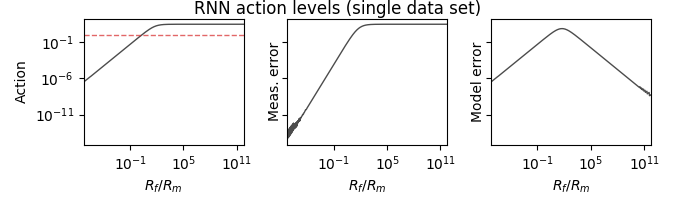

In [81]:
fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("RNN action levels (single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

#### Parameter estimates

In [72]:
#structure = np.array([25, 3, 4])
Nbias = np.sum(structure[1:])
Nweight = np.sum(structure[1:] * structure[:-1])

sortedp = []

West = np.load("l96/results/W.npy")
best = np.load("l96/results/b.npy")

for i in xrange(len(gammas_all)):
    #West = np.load("W.npy")
    #best = np.load("b.npy")
    for j, West_n in enumerate(West[i]):
        if j == 0:
            pest = West_n.flatten()#, best_n.flatten())
        else:
            pest = np.append(pest, West_n.flatten())
    for j, best_n in enumerate(best[i]):
        pest = np.append(pest, best_n.flatten())
    sortedp.append(pest.flatten())

sortedp = np.array(sortedp)

In [73]:
fig,ax = plt.subplots(1, 1, figsize=(5,4))
fig.set_tight_layout(True)

nrange = range(Nweight + Nbias)
surf = ax.pcolormesh(gammas_all, nrange, np.abs(sortedp.T), rasterized=True, cmap='jet', norm=mplcolors.LogNorm())#, vmin=1.0E-7, vmax=1.0E3)
#surf = ax.pcolormesh(g, nrange, sortedp.T, rasterized=True, cmap='jet')#, norm=mplcolors.LogNorm())
ax.set_xscale("log")
ax.set_xlabel(r"$R_f/R_m$")
ax.set_ylabel(r"Parameter metaindex")
cbar = fig.colorbar(surf, ax=ax)
cbar.set_label(r"$W$")
ax.set_xlim((gammas_all[0], gammas_all[-1]))
ax.set_ylim((nrange[0], nrange[-1]))
#ax.set_title("Est. err. vs. data, sec%d mem%d"%(secID, ensID))

plt.show()
#fig.savefig("/home/prozdeba/Desktop/plots_20170801/nnet/params_M%d.pdf"%(Ntraining,))
#plt.close()

<IPython.core.display.Javascript object>

NameError: name 'mplcolors' is not defined

### Generate Some Plots

In [75]:
sortedp[:,-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [ ]:
def feedforward(x, W, b, t):
    """Will try to estimate the data until 't' using the weights and bias values estimated by VarAnneal
    
    x: 3 data points to try estimating the full time series
    w: weight matrices
    b: bias values
    t: how far in steps to estimate
    """
    l0 = x
    l1 = sigmoid(np.dot(x, W))
    
    
    
t = 100 #estimate up to 100 points


plt.plot(data)